In [1]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)

In [2]:
import os
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import yaml
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Path to the job_logs folder
folder_path = "job_logs"

# Load the YAML file
with open('taxonomy.yaml') as file:
    taxonomy = yaml.safe_load(file)

# List to store the extracted information
data = []

In [3]:
# Iterate over the files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    # Open the file and read its content
    with open(file_path, "r") as file:
        content = file.read()

    # Initialize field variables
    job_id = ""
    runner_version = ""
    executor = ""
    image = ""
    source_checkout = ""
    artifact_download = ""
    error_messages = []
    stack_traces = []

    # Extract the important information from the file content
    job_id = filename.split(".")[0]

    try:
        runner_version = content.split("Running with gitlab-runner ")[1].split(" ")[0]
    except IndexError:
        print(f"Skipping field 'Runner Version' in file {filename} due to missing or invalid format.")

    try:
        executor = content.split("Preparing the \"")[1].split("\" executor")[0]
    except IndexError:
        print(f"Skipping field 'Executor' in file {filename} due to missing or invalid format.")

    try:
        image = content.split("Using Docker executor with image ")[1].split("\n")[0]
    except IndexError:
        print(f"Skipping field 'Image' in file {filename} due to missing or invalid format.")

    try:
        source_checkout = content.split("Checking out ")[1].split(" as ")[0]
    except IndexError:
        print(f"Skipping field 'Source Checkout' in file {filename} due to missing or invalid format.")

    try:
        artifact_download = content.split("Downloading artifacts for ")[1].split("...")[0]
    except IndexError:
        print(f"Skipping field 'Artifact Download' in file {filename} due to missing or invalid format.")

    if "ERROR:" in content:
        error_messages = content.split("ERROR:")
        error_messages = [error_message.split("Stack trace:")[0].strip() for error_message in error_messages]

    if "Stack trace:" in content:
        stack_traces = content.split("Stack trace:")
        stack_traces = [stack_trace.strip() for stack_trace in stack_traces[1:]]

    # Preprocess error messages
    stop_words = stopwords.words("english")

    def preprocess_error_messages(messages):
        preprocessed_messages = []

        for message in messages:
            # Convert to lowercase
            message = message.lower()

            # Remove punctuation
            message = message.translate(str.maketrans("", "", string.punctuation))

            # Tokenize and remove stopwords
            tokens = word_tokenize(message)
            tokens = [word for word in tokens if word not in stop_words]

            # Join tokens back into a string
            preprocessed_message = " ".join(tokens)

            preprocessed_messages.append(preprocessed_message)

        return preprocessed_messages

    preprocessed_error_messages = preprocess_error_messages(error_messages)

    # Extract regex matches from error messages
    assigned_taxonomies = set()  # Track assigned taxonomies to avoid duplicates
    deconflict_order = taxonomy['taxonomy']['deconflict_order']
    deconflict_order_dict = {error_class: index for index, error_class in enumerate(deconflict_order)}
    for error_class in deconflict_order:
        patterns = taxonomy['taxonomy']['error_classes'].get(error_class)

        if patterns is None:
            print(f"Error: Patterns are not defined for error class '{error_class}'")
            continue

        grep_for = patterns.get('grep_for')
        if grep_for is None:
            print(f"Error: 'grep_for' field is missing or set to None for error class '{error_class}'")
            continue

        # Count the number of matches for each pattern
        count = 0
        for pattern in grep_for:
            matches = re.findall(pattern, content, re.IGNORECASE)
            count += len(matches)

        if count > 0:
            # Add the log file, job ID, and error taxonomy to the DataFrame
            assigned_taxonomies.add(error_class)

    # If multiple taxonomies were assigned, sort them based on the deconflict order
    if len(assigned_taxonomies) > 1:
        sorted_taxonomies = sorted(assigned_taxonomies, key=lambda x: deconflict_order_dict[x])

    # Add the extracted information to the data list
    data.append([
        job_id, runner_version, executor, image, source_checkout,
        artifact_download, preprocessed_error_messages, stack_traces, sorted_taxonomies
    ])

# Create a DataFrame from the extracted data
df = pd.DataFrame(data, columns=[
    "Job ID", "Runner Version", "Executor", "Image", "Source Checkout",
    "Artifact Download", "Preprocessed Error Messages", "Stack Traces", "Taxonomies"
])

print(df.shape)

Skipping field 'Image' in file 7014661.log due to missing or invalid format.
Skipping field 'Image' in file 7037993.log due to missing or invalid format.
Skipping field 'Image' in file 7037346.log due to missing or invalid format.
Skipping field 'Image' in file 7014692.log due to missing or invalid format.
Skipping field 'Image' in file 7025856.log due to missing or invalid format.
Skipping field 'Image' in file 7037026.log due to missing or invalid format.
Skipping field 'Image' in file 7008241.log due to missing or invalid format.
Skipping field 'Image' in file 7011417.log due to missing or invalid format.
Skipping field 'Image' in file 7028799.log due to missing or invalid format.
Skipping field 'Image' in file 6981272.log due to missing or invalid format.
Skipping field 'Image' in file 7047247.log due to missing or invalid format.
Skipping field 'Image' in file 7036221.log due to missing or invalid format.
Skipping field 'Image' in file 7059953.log due to missing or invalid format.

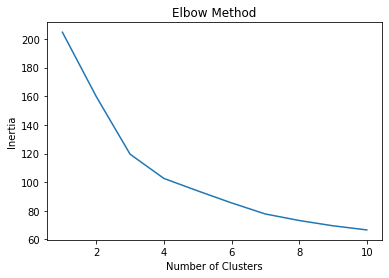

In [4]:
# Convert preprocessed error messages to feature vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Preprocessed Error Messages"].apply(lambda x: ' '.join(x)))

# Perform K-means clustering with the elbow method
max_clusters = 10
inertia_values = []

for num_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, max_clusters + 1), inertia_values)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [5]:
# Perform DBSCAN clustering with silhouette analysis
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_values = [3, 4, 5, 6, 7]
silhouette_scores = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X)

        unique_labels = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # Exclude noise label (-1)
        if unique_labels < 2:
            continue  # Skip calculating silhouette score for insufficient labels

        silhouette_avg = silhouette_score(X, dbscan_labels)
        silhouette_scores.append((eps, min_samples, silhouette_avg))

# Find the parameters with the highest silhouette score
best_eps, best_min_samples, best_silhouette = max(silhouette_scores, key=lambda x: x[2])
print(f"Best EPS: {best_eps}")
print(f"Best Min Samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette}")

Best EPS: 0.4
Best Min Samples: 4
Best Silhouette Score: 0.27979156427536794


/home/mmukherj/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mmukherj/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


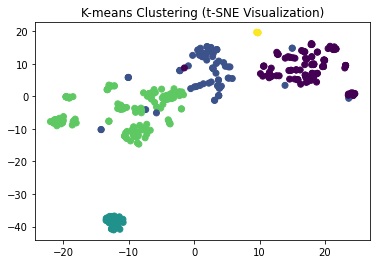

In [6]:
# Perform K-means clustering with the optimal number of clusters
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X)

# Perform DBSCAN clustering with the optimal parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(X)

# Assign cluster labels to the DataFrame
df["Cluster Labels KNN"] = kmeans.labels_
df["Cluster Labels DBSCAN"] = dbscan_labels

# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")
hierarchical_labels = hierarchical.fit_predict(X.toarray())

# Add the hierarchical clustering labels to the DataFrame
df["Hierarchical Cluster"] = hierarchical_labels


# Plot the clusters using t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Create a scatter plot of the t-SNE transformed data
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_)
plt.title("K-means Clustering (t-SNE Visualization)")
plt.show()

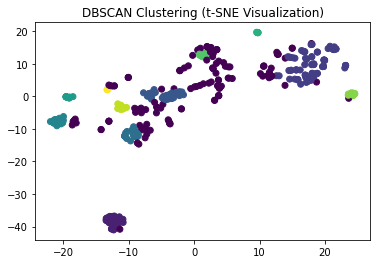

In [7]:
# Create a scatter plot of the t-SNE transformed data with DBSCAN labels
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels)
plt.title("DBSCAN Clustering (t-SNE Visualization)")
plt.show()

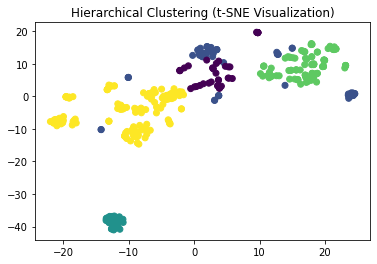

In [8]:
# Create a scatter plot of the t-SNE transformed data with hierarchical clustering labels
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_labels)
plt.title("Hierarchical Clustering (t-SNE Visualization)")
plt.show()

In [9]:
df

,Job ID,Runner Version,Executor,Image,Source Checkout,Artifact Download,Preprocessed Error Messages,Stack Traces,Taxonomies,Cluster Labels KNN,Cluster Labels DBSCAN,Hierarchical Cluster
0,7014661,14.7.0,kubernetes,,add256f5,aws-pcluster-generate-neoverse_n1 (7014402),[0krunning gitlabrunner 1470 98daeee00m 0k ...,[],"[spack_error, file_not_found]",2,0,2
1,7037993,14.7.0,kubernetes,,f2e6e302,e4s-generate (7029999),[0krunning gitlabrunner 1470 98daeee00m 0k ...,[],"[spack_error, file_not_found]",0,1,3
2,7037346,14.7.0,kubernetes,,f2e6e302,data-vis-sdk-generate (7030007),[0krunning gitlabrunner 1470 98daeee00m 0k ...,[],"[spack_error, file_not_found]",0,1,3
3,7014692,14.7.0,kubernetes,,add256f5,aws-pcluster-generate-neoverse_v1 (7014403),[0krunning gitlabrunner 1470 98daeee00m 0k ...,[],"[spack_error, file_not_found]",2,0,2
4,7025856,14.7.0,kubernetes,,74af5534,aws-pcluster-generate-neoverse_v1 (7025367),[0krunning gitlabrunner 1470 98daeee00m 0k ...,[],"[spack_error, file_not_found]",3,2,4
5,7022840,14.10.1,docker,ecpe4s/ubuntu20.04-runner-x86_64:2023-01-01 .....,7ad964ef,e4s-generate (7022398),[0krunning gitlabrunner 14101 f761588f0m 0k...,[],"[spack_error, file_not_found]",3,3,4
6,7037026,14.7.0,kubernetes,,74af5534,aws-pcluster-generate-neoverse_n1 (7036284),[0krunning gitlabrunner 1470 98daeee00m 0k ...,[],"[spack_error, file_not_found]",3,2,4
7,7008241,14.7.0,kubernetes,,cb1f0f23,data-vis-sdk-generate (7006955),[0krunning gitlabrunner 1470 98daeee00m 0k ...,[],"[spack_error, file_not_found]",1,-1,0
8,7011417,14.7.0,kubernetes,,cb1f0f23,aws-ahug-aarch64-generate (7006957),[0krunning gitlabrunner 1470 98daeee00m 0k ...,[],"[spack_error, file_not_found]",3,-1,4
9,7028799,14.7.0,kubernetes,,74af5534,e4s-oneapi-generate (7026141),[0krunning gitlabrunner 1470 98daeee00m 0k ...,[],"[spack_error, file_not_found]",3,4,4
